In [10]:
# use the nolearn environment (source activate nolearn) to run this notebook
# Documentation: https://github.com/dnouri/nolearn/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from nolearn.lasagne import NeuralNet
from sklearn.datasets import make_regression

%matplotlib inline

#### Eventually, make this into a function that reads the data, cleans it appropriately, shuffles and normalizes it, and splits it into training/test sets

In [6]:
# Read the training data for the neural network
# Input data is 250000x4 and output data is 250000x32
x = pd.read_csv('../parameters_250000.txt', sep=' ')
y = pd.read_csv('../results.txt', sep=' ', index_col=False)
# These functional groups do not exist in my model
y = y.drop(['light_aromatic_C-C', 'light_aromatic_methoxyl'], axis=1)

In [15]:
x = x.values.astype(np.float32)
y = y.values.astype(np.float32)

I am going to follow the regression example in this tutorial to start figuring out nolearn:

http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/

For regression problems, I want the activation function for the output layer to be a rectified linear unit.

In [16]:
print x.shape, y.shape

(250000, 4) (250000, 30)


In [17]:
# net = NeuralNet(
#     layers=[
#         ('input', lasagne.layers.InputLayer),
#         ('hidden', lasagne.layers.DenseLayer),
#         ('output', lasagne.layers.DenseLayer),
#         ]), 
#     # layer parameters
#     input_shape=()

In [21]:
l = InputLayer(shape=(None, x.shape[1]))
l = DenseLayer(l, num_units=50, nonlinearity=lasagne.nonlinearities.sigmoid)
l = DenseLayer(l, num_units=y.shape[1],
               nonlinearity=lasagne.nonlinearities.linear)
net = NeuralNet(l, regression=True, update_learning_rate=0.1, verbose=1)
net.fit(x, y)
print(net.score(x, y))


# Neural Network with 1780 learnable parameters

## Layer information

  #    name    size
---  ------  ------
  0               4
                 50
                 30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.00624       0.00501      1.24637  0.61s
      2       0.00501       0.00497      1.00627  0.57s
      3       0.00497       0.00494      1.00484  0.60s
      4       0.00496       0.00495      1.00271  0.58s
      5       0.00496       0.00495      1.00289  0.59s
      6       0.00496       0.00494      1.00300  0.59s
      7       0.00496       0.00494      1.00318  0.58s
      8       0.00496       0.00495      1.00229  0.57s
      9       0.00496       0.00494      1.00341  0.59s
     10       0.00495       0.00494      1.00290  0.58s
     11       0.00495       0.00494      1.00260  0.58s
     12       0.00495       0.00494      1.00318  0.59s
     13       0.00495       0.00494      1.002

0.00493332126885


In [23]:
y_predictions = net.predict(x)
y_predictions.shape

(250000, 30)

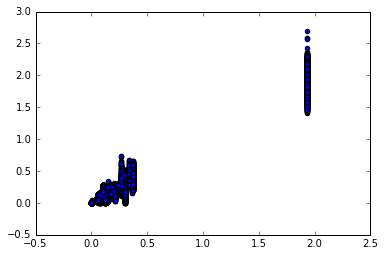

In [29]:
plt.scatter(y_predictions[:1000,:].flatten(), y[:1000,:].flatten())

In [ ]:
np.flatt